<a href="https://colab.research.google.com/github/juliano-lopes/sistema-inteligente/blob/main/Avalia%C3%A7%C3%A3o_de_score_de_cliente.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP de Engenharia de Sistemas de Software Inteligentes
## Objetivo  
O objetivo deste modelo é predizer se o score de crédito de um cliente deve ser Baixo, Regular ou Alto. Assim a instituição, com base nos dados dos clientes registrados, conseguirá tomar a decisão de liberação de crédito com um maior nível de confiança.

In [1]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from pickle import dump
from pickle import load
from imblearn.under_sampling import RandomUnderSampler

In [2]:
# funcoes para o modelo
def limpar_dados(dataframe):
    dataframe['salario_anual'] = pd.to_numeric(dataframe['salario_anual'], errors='coerce')
    dataframe.dropna(inplace=True)
    print(dataframe[dataframe['score_credito'] == 'Alto'].shape[0])
    print(dataframe[dataframe['score_credito'] == 'Regular'].shape[0])
    print(dataframe[dataframe['score_credito'] == 'Baixo'].shape[0])
    return dataframe

def balancear(dataframe):
    X = dataframe.drop('score_credito', axis=1)
    y = dataframe['score_credito']
    # balanceando
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X, y)
    print("Balanceado")
    print(pd.Series(y_resampled).value_counts())
    return     X_resampled, y_resampled

def normalizar(scaler, X_input):
    # normalizar dados
    rescaledX = scaler.transform(X_input) # aplicação da normalização  no conjunto de treino
    return rescaledX



## Carga do Dataset com os dados de clientes

In [12]:
#  URL de importação do dataset
url = "https://raw.githubusercontent.com/juliano-lopes/sistema-inteligente/refs/heads/main/dados_de_clientes.csv"
# colunas do dataset a serem utilizadas (colunas comentadas foram retiradas por terem menor  importância e faziam com que acuracia fosse baixa)
cols = [
    'idade',
    'salario_anual',
    'num_contas',
    #'num_cartoes',
    'juros_emprestimo',
    'num_emprestimos',
    'dias_atraso',
    'num_pagamentos_atrasados',
    'divida_total',
    #'investimento_mensal',
    'score_credito'
    ]

# Lê o arquivo
dataset = pd.read_csv(url, usecols=cols, delimiter=',')
# Mostra as primeiras linhas do dataset
dataset.head()

,idade,salario_anual,num_contas,juros_emprestimo,num_emprestimos,dias_atraso,num_pagamentos_atrasados,divida_total,score_credito
0,36.0,10.007.815,4.0,8.0,7.0,7.0,6.0,2195.63,Regular
1,27.0,121688.04,7.0,12.0,4.0,18.0,13.0,54.68,Regular
2,27.0,121688.04,7.0,12.0,4.0,20.0,13.0,54.68,Regular
3,27.0,121688.04,7.0,12.0,4.0,20.0,15.0,54.68,Regular
4,27.0,121688.04,7.0,12.0,4.0,20.0,15.0,54.68,Regular


In [4]:

# verificar se temos valores vazios ou valores reconhecidos em formato errado
print(dataset.info())
print(dataset.columns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98001 entries, 0 to 98000
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   idade                     98001 non-null  float64
 1   salario_anual             98001 non-null  object 
 2   num_contas                98001 non-null  float64
 3   juros_emprestimo          98001 non-null  float64
 4   num_emprestimos           98001 non-null  float64
 5   dias_atraso               98001 non-null  float64
 6   num_pagamentos_atrasados  98001 non-null  float64
 7   divida_total              98001 non-null  float64
 8   score_credito             98001 non-null  object 
dtypes: float64(7), object(2)
memory usage: 6.7+ MB
None
Index(['idade', 'salario_anual', 'num_contas', 'juros_emprestimo',
       'num_emprestimos', 'dias_atraso', 'num_pagamentos_atrasados',
       'divida_total', 'score_credito'],
      dtype='object')


In [5]:

# limpar dados
dataset = limpar_dados(dataset)
print(dataset.info())
dataset.head()

15664
46620
25508
<class 'pandas.core.frame.DataFrame'>
Index: 87792 entries, 1 to 98000
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   idade                     87792 non-null  float64
 1   salario_anual             87792 non-null  float64
 2   num_contas                87792 non-null  float64
 3   juros_emprestimo          87792 non-null  float64
 4   num_emprestimos           87792 non-null  float64
 5   dias_atraso               87792 non-null  float64
 6   num_pagamentos_atrasados  87792 non-null  float64
 7   divida_total              87792 non-null  float64
 8   score_credito             87792 non-null  object 
dtypes: float64(8), object(1)
memory usage: 6.7+ MB
None


,idade,salario_anual,num_contas,juros_emprestimo,num_emprestimos,dias_atraso,num_pagamentos_atrasados,divida_total,score_credito
1,27.0,121688.04,7.0,12.0,4.0,18.0,13.0,54.68,Regular
2,27.0,121688.04,7.0,12.0,4.0,20.0,13.0,54.68,Regular
3,27.0,121688.04,7.0,12.0,4.0,20.0,15.0,54.68,Regular
4,27.0,121688.04,7.0,12.0,4.0,20.0,15.0,54.68,Regular
5,27.0,121688.04,7.0,12.0,4.0,20.0,15.0,54.68,Regular


## preprocessamento

In [6]:
# balanceamento de classes
X, y = balancear(dataset)


Balanceado
score_credito
Alto       15664
Baixo      15664
Regular    15664
Name: count, dtype: int64


In [7]:
# Separação em conjuntos de treino e teste
test_size = 0.20 # tamanho do conjunto de teste
seed = 7 # semente aleatória

X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

## Modelagem e Inferência

### Criação e avaliação de modelos: linha base

KNN: 0.711276 (0.006282)
randomforestclassifier: 0.791876 (0.006924)
CART: 0.758279 (0.006240)
NB: 0.635996 (0.005565)
SVM: 0.539356 (0.004224)


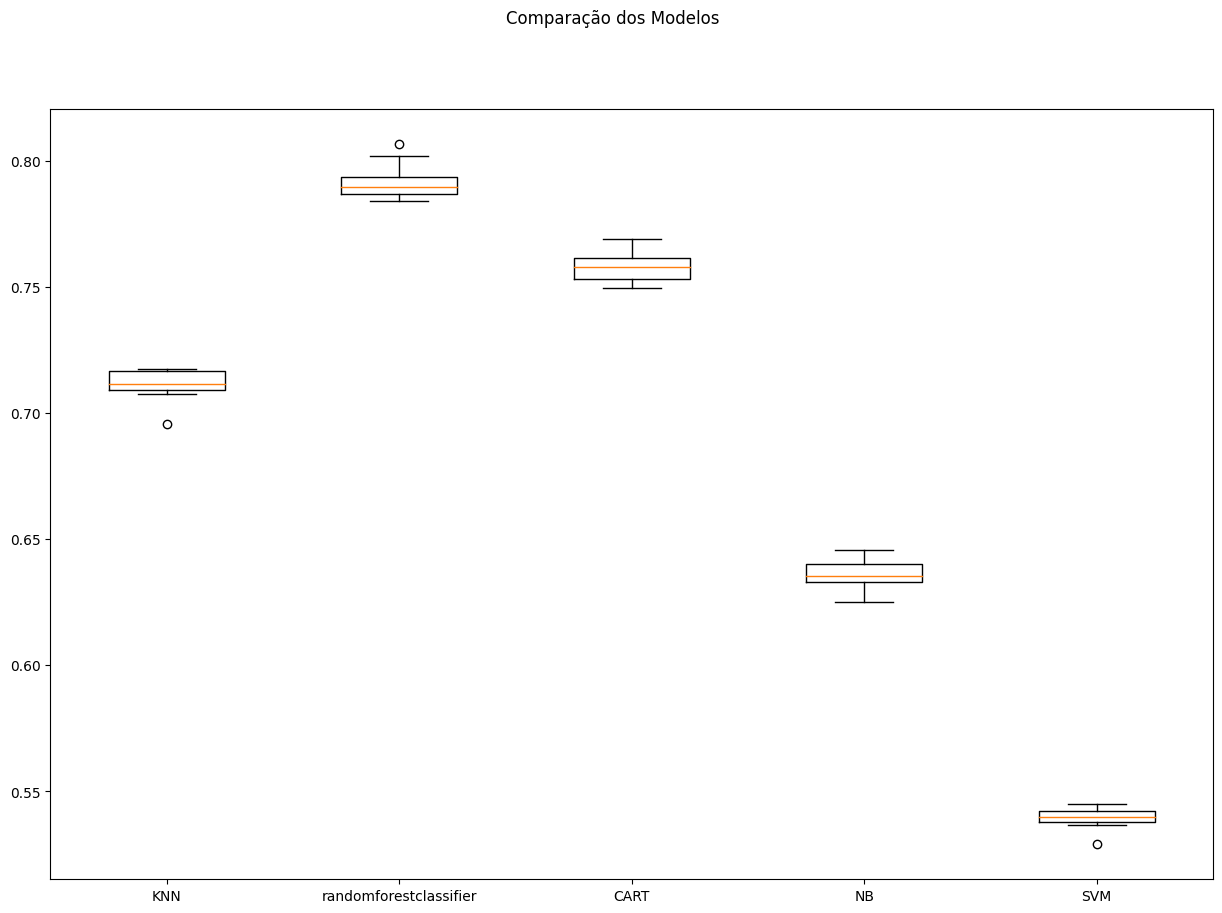

In [8]:
np.random.seed(7) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('KNN', KNeighborsClassifier()))
models.append(('randomforestclassifier', RandomForestClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Criação e avaliação de modelos: dados padronizados e normalizados

KNN-orig: 0.711 (0.006)
RF-orig: 0.792 (0.007)
CART-orig: 0.758 (0.006)
NB-orig: 0.636 (0.006)
SVM-orig: 0.539 (0.004)
KNN-padr: 0.748 (0.004)
RF-padr: 0.790 (0.006)
CART-padr: 0.757 (0.006)
NB-padr: 0.639 (0.005)
SVM-padr: 0.684 (0.006)
KNN-norm: 0.747 (0.004)
RF-norm: 0.792 (0.007)
CART-norm: 0.759 (0.008)
NB-norm: 0.639 (0.005)
SVM-norm: 0.683 (0.006)


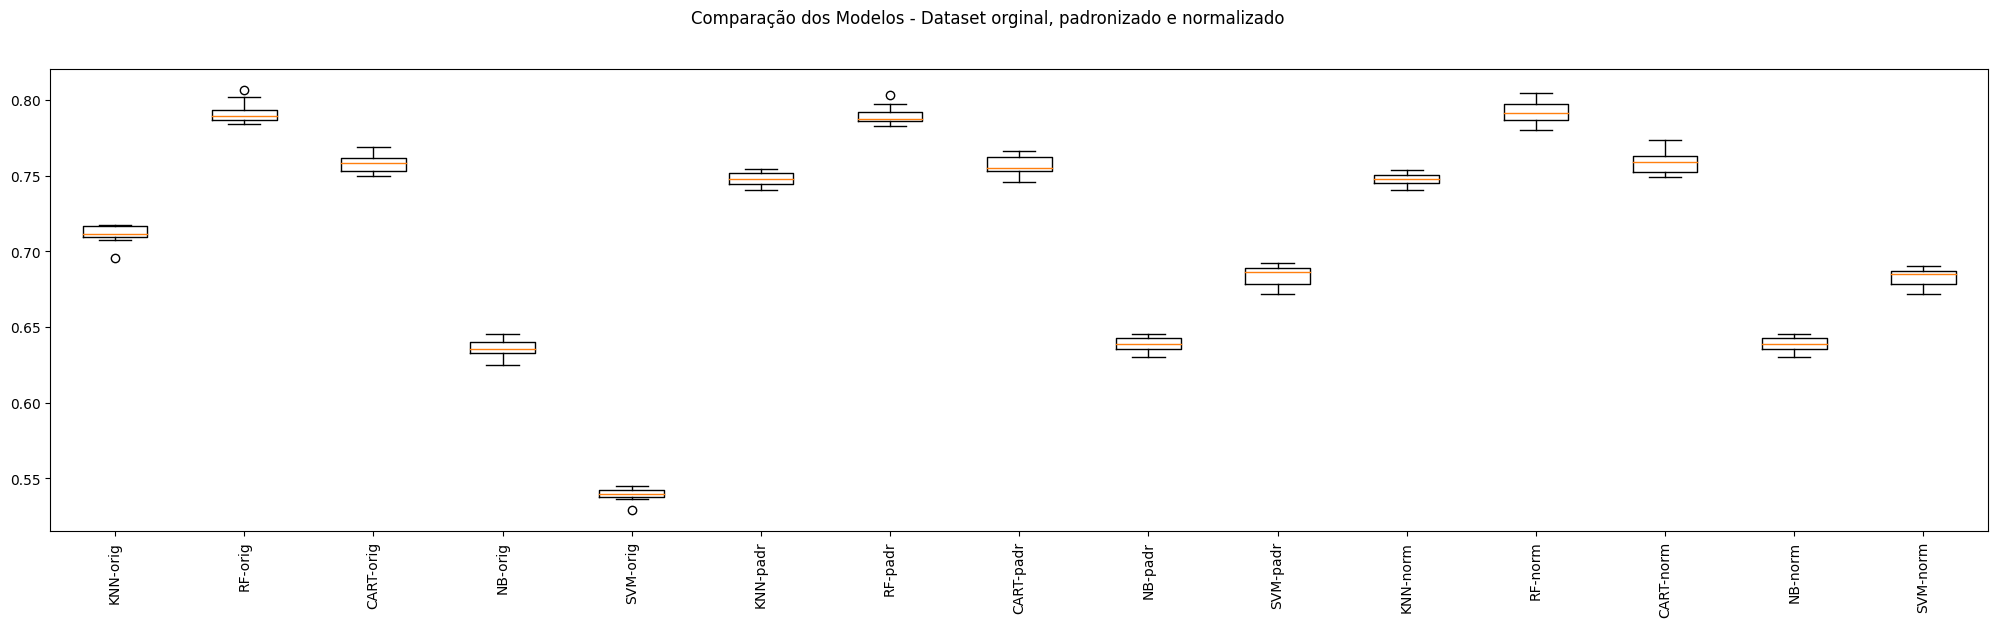

In [9]:
np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []


# Criando os elementos do pipeline

# Algoritmos que serão utilizados
knn = ('KNN', KNeighborsClassifier())
rf = ('randomforestclassifier', RandomForestClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

# Montando os pipelines

# Dataset original
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('RF-orig', Pipeline([rf])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))

# Dataset Padronizado
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('RF-padr', Pipeline([standard_scaler, rf])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))

# Dataset Normalizado
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('RF-norm', Pipeline([min_max_scaler, rf])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

### Otimização dos hiperparâmetros

In [10]:
# Tuning do RandomForest pois obteve melhor acurácia

np.random.seed(7) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
rf = ('randomforestclassifier', RandomForestClassifier())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('rf-orig', Pipeline(steps=[rf])))
pipelines.append(('rf-padr', Pipeline(steps=[standard_scaler, rf])))
pipelines.append(('rf-norm', Pipeline(steps=[min_max_scaler, rf])))

# Definindo os parâmetros para o Random Forest

param_grid = {
    'randomforestclassifier__n_estimators': [140, 210, 300],
    'randomforestclassifier__max_depth': [None, 2, 4],
    'randomforestclassifier__min_samples_split': [3, 5, 7]
    #'randomforestclassifier__min_samples_leaf': [1, 3],
    #'randomforestclassifier__max_features': ['auto', 'sqrt', 'log2'],
    #'randomforestclassifier__criterion': ['gini', 'entropy']
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Sem tratamento de missings: rf-orig - Melhor: 0.797276 usando {'randomforestclassifier__max_depth': None, 'randomforestclassifier__min_samples_split': 5, 'randomforestclassifier__n_estimators': 300}
Sem tratamento de missings: rf-padr - Melhor: 0.796691 usando {'randomforestclassifier__max_depth': None, 'randomforestclassifier__min_samples_split': 5, 'randomforestclassifier__n_estimators': 300}
Sem tratamento de missings: rf-norm - Melhor: 0.795973 usando {'randomforestclassifier__max_depth': None, 'randomforestclassifier__min_samples_split': 5, 'randomforestclassifier__n_estimators': 140}


## Finalização do Modelo

In [8]:
# Avaliação do modelo com o conjunto de testes
model = RandomForestClassifier(n_estimators=300, min_samples_split=5, max_depth=None,  random_state=42)

# Preparação do modelo com
#  com normalização
scaler = MinMaxScaler().fit(X_train) # ajuste do scaler com o conjunto de treino
rescaledX = scaler.transform(X_train) # aplicação da normalização  no conjunto de treino
model.fit(rescaledX, y_train)
# Estimativa da acurácia no conjunto de teste
rescaledTestX = scaler.transform(X_test) # aplicação da normalização  no conjunto de teste
predictions = model.predict(rescaledTestX)

# sem normalização

#model.fit(X_train, y_train)
#cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
#print(cv_results)
# Estimativa da acurácia no conjunto de teste
#predictions = model.predict(X_test)

print(accuracy_score(y_test, predictions))

0.8097669964889882


In [9]:
# Preparação do modelo com TODO o dataset
# com scaler
scaler = MinMaxScaler().fit(X) # ajuste do scaler com TODO o dataset
rescaledX = scaler.transform(X) # aplicação da normalização  com TODO o dataset
model.fit(rescaledX, y)
# sem scaler
#model.fit(X, y)

importances = model.feature_importances_

# Criando um DataFrame com as importâncias
df_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})

# Ordenando por importância decrescente
df_importances = df_importances.sort_values('importance', ascending=False)

# Imprimindo o DataFrame
print(df_importances)


                    feature  importance
7              divida_total    0.220074
3          juros_emprestimo    0.169957
5               dias_atraso    0.144112
1             salario_anual    0.118795
6  num_pagamentos_atrasados    0.094671
0                     idade    0.094163
2                num_contas    0.087130
4           num_emprestimos    0.071098


## Simulando a aplicação do modelo em dados não vistos

In [11]:

# dados de testes que não estão no dataset de treino
# Informa a URL de importação do dataset_new de teste com dados não vistos
url_new = "https://raw.githubusercontent.com/juliano-lopes/sistema-inteligente/refs/heads/main/dados_de_clientes_teste.csv"

# Lê o arquivo
dataset_new = pd.read_csv(url_new, usecols=cols, delimiter=',')
dataset = limpar_dados(dataset_new)
X_new, y_new = balancear(dataset_new)
rescaledNewX = normalizar(scaler, X_new)
predictions_new = model.predict(rescaledNewX)

# sem scaler
#predictions_new = model.predict(X_new)

print(f"acurácia do teste: {accuracy_score(y_new, predictions_new)}")

361
930
469
Balanceado
score_credito
Alto       361
Baixo      361
Regular    361
Name: count, dtype: int64
acurácia do teste: 0.7192982456140351


In [ ]:
# Novos dados  com classes ainda não determinadas

data = {'idade':  [25, 34, 46],
        'salario_anual': [19000.33, 34148.50, 30144.22],
        'num_contas': [1, 3, 2],
        #'num_cartoes': [1, 3, 2],
        'juros_emprestimo': [29.55, 15.33, 6.38],
        'num_emprestimos': [15, 9, 3],
        'dias_atraso': [60, 20, 4],
        'num_pagamentos_atrasados': [30, 9, 1],
        'divida_total': [20345.33, 1000.55, 835.00],
        #'investimento_mensal': [1.55, 0.00, 10.33],
        }
atributos = list(data.keys())
print(atributos)
entrada = pd.DataFrame(data, columns=atributos)
X_entrada = entrada.values

# normalização  nos dados de entrada usando o scaler utilizado em X
rescaledEntradaX = normalizar(scaler, X_entrada)


['idade', 'salario_anual', 'num_contas', 'juros_emprestimo', 'num_emprestimos', 'dias_atraso', 'num_pagamentos_atrasados', 'divida_total']


In [ ]:
# Predição de classes dos dados de entrada com scaler
saidas = model.predict(rescaledEntradaX)
# Predição de classes dos dados de entrada sem scaler
#saidas = model.predict(X_entrada)

print(saidas)

['Baixo' 'Regular' 'Alto']


In [ ]:
# Salva o modelo escolhido no disco
filename = 'model_rf_minmaxscaler.pkl'
dump(model, open(filename, 'wb'))


In [ ]:

# Salva o scaler utilizado  no disco
filename_s = 'scaler_model_rf_minmaxscaler.pkl'
dump(scaler, open(filename_s, 'wb'))